#Полезные ссылки:

https://towardsdatascience.com/modeling-customer-lifetime-value-with-lifetimes-71171a35f654 - lifetimes

https://btyd.readthedocs.io/en/latest/User%20Guide.html#rfm-data-format - btyd user guide

https://btyd.readthedocs.io/en/latest/api_reference.html - btyd docs

# Импорт библиотек

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

!pip install lifetimes
!pip install --upgrade btyd
from btyd import BetaGeoFitter
from btyd.utils import summary_data_from_transaction_data, calibration_and_holdout_data
from btyd.plotting import plot_probability_alive_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_validate, ShuffleSplit, GridSearchCV
from sklearn.metrics import f1_score, precision_score, recall_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline

import warnings
warnings.filterwarnings('ignore')

#Преобразование данных в RFM формат

## С использованием библиотеки

In [ ]:
df = pd.read_parquet('/content/drive/MyDrive/Practice/wallet_urfu.parquet.gzip')
df

,partner,rep_date,monetary
0,468726,2016-01-02,2.673749e-11
1,134145,2016-01-02,1.069500e-12
2,66774,2016-01-02,2.228576e-12
3,178928,2016-01-02,8.730611e-11
4,679693,2016-01-02,3.492244e-11
...,...,...,...
52032794,636021,2023-02-23,4.365305e-12
52032795,1408806,2023-02-23,5.896654e-12
52032796,360238,2023-02-23,4.365305e-12
52032797,1007996,2023-02-23,6.547958e-13


In [ ]:
rfm = summary_data_from_transaction_data(transactions=df,
                                         customer_id_col='partner',
                                         datetime_col='rep_date',
                                         observation_period_end=('2023-02-23'))
rfm

In [ ]:
rfm.to_parquet('/content/drive/MyDrive/Practice/rfm_sum_data.parquet.gzip', compression='gzip')

In [ ]:
rfm_cal_holdout = calibration_and_holdout_data(
    transactions=df,
    customer_id_col='partner',
    datetime_col='rep_date',
    calibration_period_end='2022-11-20',
    observation_period_end='2023-02-23'
    )

rfm_cal_holdout

In [ ]:
rfm_cal_holdout.to_parquet('/content/drive/MyDrive/Practice/rfm_cal_holdout.parquet.gzip', compression='gzip')

## Вручную

In [ ]:
df

,partner,rep_date,monetary
0,468726,2016-01-02,2.673749e-11
1,134145,2016-01-02,1.069500e-12
2,66774,2016-01-02,2.228576e-12
3,178928,2016-01-02,8.730611e-11
4,679693,2016-01-02,3.492244e-11
...,...,...,...
52032794,636021,2023-02-23,4.365305e-12
52032795,1408806,2023-02-23,5.896654e-12
52032796,360238,2023-02-23,4.365305e-12
52032797,1007996,2023-02-23,6.547958e-13


In [ ]:
df['rep_date'] = pd.to_datetime(df['rep_date'])

In [ ]:
frequency = df['partner'].value_counts()
df_frequency = pd.DataFrame({'partner':frequency.index, 'frequency':frequency.values})
df_frequency.set_index('partner', inplace=True)
df_frequency

,frequency
partner,
147154,1138
713001,991
181706,987
708510,966
88817,959
...,...
543894,1
1295909,1
627040,1


In [ ]:
first_date = df.groupby('partner')['rep_date'].first().to_frame()
first_date.rename(columns = {'rep_date': 'first_date'}, inplace=True)
first_date

,first_date
partner,
0,2016-01-27
1,2016-01-15
2,2016-03-04
3,2016-04-01
4,2016-01-04
...,...
1695379,2016-07-26
1695380,2016-03-22
1695381,2016-09-06


In [ ]:
last_date = df.groupby('partner')['rep_date'].last().to_frame()
last_date.rename(columns = {'rep_date': 'last_date'}, inplace=True)
last_date

,last_date
partner,
0,2023-02-15
1,2023-02-22
2,2023-02-01
3,2022-07-13
4,2022-12-26
...,...
1695379,2019-09-20
1695380,2017-06-19
1695381,2022-02-25


In [ ]:
result_df = first_date.merge(last_date, on = 'partner')
result_df = result_df.merge(df_frequency, on = 'partner')

end_date = '2023-02-23'
result_df['end_date'] = end_date
result_df['end_date'] = pd.to_datetime(result_df['end_date'])

result_df['recency'] = result_df['last_date'] - result_df['first_date']
result_df['T'] = result_df['end_date'] - result_df['first_date']
result_df['recency'] = result_df['recency'].dt.days.astype('int')
result_df['T'] = result_df['T'].dt.days.astype('int')
result_df.drop(columns = ['first_date', 'last_date', 'end_date'], inplace = True)
result_df

,frequency,recency,T
partner,,,
0,138,2576,2584
1,267,2595,2596
2,58,2525,2547
3,7,2294,2519
4,179,2548,2607
...,...,...,...
1695379,4,1151,2403
1695380,3,454,2529
1695381,23,1998,2361


In [ ]:
result_df.to_parquet('/content/drive/MyDrive/Practice/rfm_without_library.parquet.gzip', compression='gzip')

In [ ]:
df_cal = df[df['rep_date'] < '2022-11-20']
df_cal

,partner,rep_date,monetary
0,468726,2016-01-02,2.673749e-11
1,134145,2016-01-02,1.069500e-12
2,66774,2016-01-02,2.228576e-12
3,178928,2016-01-02,8.730611e-11
4,679693,2016-01-02,3.492244e-11
...,...,...,...
48847364,1624347,2022-11-19,1.066815e-12
48847365,1514004,2022-11-19,4.365305e-12
48847366,1014174,2022-11-19,4.365305e-12
48847367,572310,2022-11-19,1.309592e-13


In [ ]:
df_holdout = df[df['rep_date'] > '2022-11-20']
df_holdout

,partner,rep_date,monetary
48863012,636242,2022-11-21,6.526131e-13
48863013,194847,2022-11-21,2.837448e-12
48863014,685964,2022-11-21,1.091108e-13
48863015,1653407,2022-11-21,1.381619e-12
48863016,139344,2022-11-21,1.102805e-11
...,...,...,...
52032794,636021,2023-02-23,4.365305e-12
52032795,1408806,2023-02-23,5.896654e-12
52032796,360238,2023-02-23,4.365305e-12
52032797,1007996,2023-02-23,6.547958e-13


In [ ]:
frequency_cal = df_cal['partner'].value_counts()
df_cal_frequency = pd.DataFrame({'partner':frequency_cal.index, 'frequency_cal':frequency_cal.values})
df_cal_frequency.set_index('partner', inplace=True)
df_cal_frequency

,frequency_cal
partner,
147154,1110
713001,949
181706,949
200606,929
708510,925
...,...
1137117,1
444289,1
185687,1


In [ ]:
frequency_holdout = df_holdout['partner'].value_counts()
df_holdout_frequency = pd.DataFrame({'partner':frequency_holdout.index, 'frequency_holdout':frequency_holdout.values})
df_holdout_frequency.set_index('partner', inplace=True)
df_holdout_frequency

,frequency_holdout
partner,
1566137,60
1110784,54
1446426,52
1366380,52
1598113,51
...,...
294519,1
1146982,1
743770,1


In [ ]:
first_date_cal = df_cal.groupby('partner')['rep_date'].first().to_frame()
first_date_cal.rename(columns = {'rep_date': 'first_date_cal'}, inplace=True)
first_date_cal

,first_date_cal
partner,
0,2016-01-27
1,2016-01-15
2,2016-03-04
3,2016-04-01
4,2016-01-04
...,...
1695379,2016-07-26
1695380,2016-03-22
1695381,2016-09-06


In [ ]:
last_date_cal = df_cal.groupby('partner')['rep_date'].last().to_frame()
last_date_cal.rename(columns = {'rep_date': 'last_date_cal'}, inplace=True)
last_date_cal

,last_date_cal
partner,
0,2022-11-15
1,2022-11-15
2,2022-11-15
3,2022-07-13
4,2022-11-01
...,...
1695379,2019-09-20
1695380,2017-06-19
1695381,2022-02-25


In [ ]:
result_df_cal = first_date_cal.merge(last_date_cal, on = 'partner')
result_df_cal = result_df_cal.merge(df_cal_frequency, on = 'partner')

end_cal_date = '2022-11-20'
result_df_cal['end_cal_date'] = end_cal_date
result_df_cal['end_cal_date'] = pd.to_datetime(result_df_cal['end_cal_date'])

result_df_cal['recency_cal'] = result_df_cal['last_date_cal'] - result_df_cal['first_date_cal']
result_df_cal['T_cal'] = result_df_cal['end_cal_date'] - result_df_cal['first_date_cal']
result_df_cal['recency_cal'] = result_df_cal['recency_cal'].dt.days.astype('int')
result_df_cal['T_cal'] = result_df_cal['T_cal'].dt.days.astype('int')
result_df_cal.drop(columns = ['first_date_cal', 'last_date_cal', 'end_cal_date'], inplace = True)
result_df_cal

,frequency_cal,recency_cal,T_cal
partner,,,
0,134,2484,2489
1,257,2496,2501
2,55,2447,2452
3,7,2294,2424
4,178,2493,2512
...,...,...,...
1695379,4,1151,2308
1695380,3,454,2434
1695381,23,1998,2266


In [ ]:
result_df_cal_holdout = result_df_cal.merge(df_holdout_frequency, how ='left', on = 'partner')
result_df_cal_holdout['frequency_holdout'].fillna(0, inplace = True)

end_cal_date = pd.to_datetime('2022-11-20')
end_holdout_date = pd.to_datetime('2023-02-23')
result_df_cal_holdout['duration_holdout'] = end_holdout_date - end_cal_date
result_df_cal_holdout['duration_holdout'] = result_df_cal_holdout['duration_holdout'].dt.days.astype('int')
result_df_cal_holdout

,frequency_cal,recency_cal,T_cal,frequency_holdout,duration_holdout
partner,,,,,
0,134,2484,2489,4.0,95
1,257,2496,2501,10.0,95
2,55,2447,2452,3.0,95
3,7,2294,2424,0.0,95
4,178,2493,2512,1.0,95
...,...,...,...,...,...
1695379,4,1151,2308,0.0,95
1695380,3,454,2434,0.0,95
1695381,23,1998,2266,0.0,95


In [ ]:
result_df_cal_holdout.to_parquet('/content/drive/MyDrive/Practice/rfm_cal_holdout_without_library.parquet.gzip', compression='gzip')

#bgf, LogReg

## С использованием библиотеки

In [ ]:
data = pd.read_parquet('/content/drive/MyDrive/Practice/rfm_sum_data.parquet.gzip')
data

,frequency,recency,T
partner,,,
0,137.0,2576.0,2584.0
1,266.0,2595.0,2596.0
2,57.0,2525.0,2547.0
3,6.0,2294.0,2519.0
4,178.0,2548.0,2607.0
...,...,...,...
1695379,3.0,1151.0,2403.0
1695380,2.0,454.0,2529.0
1695381,22.0,1998.0,2361.0


In [ ]:
data_cal_holdout = pd.read_parquet('/content/drive/MyDrive/Practice/rfm_cal_holdout.parquet.gzip')
data_cal_holdout

,frequency_cal,recency_cal,T_cal,frequency_holdout,duration_holdout
partner,,,,,
0,133.0,2484.0,2489.0,4.0,95.0
1,256.0,2496.0,2501.0,10.0,95.0
2,54.0,2447.0,2452.0,3.0,95.0
3,6.0,2294.0,2424.0,0.0,95.0
4,177.0,2493.0,2512.0,1.0,95.0
...,...,...,...,...,...
1695379,3.0,1151.0,2308.0,0.0,95.0
1695380,2.0,454.0,2434.0,0.0,95.0
1695381,22.0,1998.0,2266.0,0.0,95.0


In [ ]:
data_clear = data_cal_holdout[data_cal_holdout['T_cal'] - data_cal_holdout['recency_cal'] < 95]
data_clear

,frequency_cal,recency_cal,T_cal,frequency_holdout,duration_holdout
partner,,,,,
0,133.0,2484.0,2489.0,4.0,95.0
1,256.0,2496.0,2501.0,10.0,95.0
2,54.0,2447.0,2452.0,3.0,95.0
4,177.0,2493.0,2512.0,1.0,95.0
9,87.0,2419.0,2498.0,0.0,95.0
...,...,...,...,...,...
1668108,0.0,0.0,0.0,15.0,95.0
1668153,0.0,0.0,0.0,31.0,95.0
1668259,0.0,0.0,0.0,30.0,95.0


In [ ]:
data_full = pd.merge(data_clear, data, on = 'partner')
data_full

,frequency_cal,recency_cal,T_cal,frequency_holdout,duration_holdout,frequency,recency,T
partner,,,,,,,,
0,133.0,2484.0,2489.0,4.0,95.0,137.0,2576.0,2584.0
1,256.0,2496.0,2501.0,10.0,95.0,266.0,2595.0,2596.0
2,54.0,2447.0,2452.0,3.0,95.0,57.0,2525.0,2547.0
4,177.0,2493.0,2512.0,1.0,95.0,178.0,2548.0,2607.0
9,87.0,2419.0,2498.0,0.0,95.0,87.0,2419.0,2593.0
...,...,...,...,...,...,...,...,...
1668108,0.0,0.0,0.0,15.0,95.0,15.0,92.0,95.0
1668153,0.0,0.0,0.0,31.0,95.0,31.0,94.0,95.0
1668259,0.0,0.0,0.0,30.0,95.0,30.0,95.0,95.0


In [ ]:
data_full['in_d_c'] = data_full['T_cal'] - data_full['recency_cal']
data_full['in_d_f'] = round((data_full['recency'] - data_full['T_cal'])/ data_full['frequency_holdout']) + data_full['in_d_c']
data_full.loc[data_full['in_d_f'] < 0, 'in_d_f'] = 100
data_full['in_d_f'].fillna(100, inplace = True)
data_full

,frequency_cal,recency_cal,T_cal,frequency_holdout,duration_holdout,frequency,recency,T,in_d_c,in_d_f,alive_prob,expected_purchases,avarage_purchases
partner,,,,,,,,,,,,,
0,133.0,2484.0,2489.0,4.0,95.0,137.0,2576.0,2584.0,5.0,27.0,0.999997,4.806272,0.053543
1,256.0,2496.0,2501.0,10.0,95.0,266.0,2595.0,2596.0,5.0,14.0,0.999998,9.167410,0.102564
2,54.0,2447.0,2452.0,3.0,95.0,57.0,2525.0,2547.0,5.0,29.0,0.999994,2.006643,0.022068
4,177.0,2493.0,2512.0,1.0,95.0,178.0,2548.0,2607.0,19.0,55.0,0.999994,5.340363,0.070999
9,87.0,2419.0,2498.0,0.0,95.0,87.0,2419.0,2593.0,79.0,100.0,0.999944,0.559553,0.035965
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1668108,0.0,0.0,0.0,15.0,95.0,15.0,92.0,95.0,0.0,6.0,1.000000,4.760449,0.000000
1668153,0.0,0.0,0.0,31.0,95.0,31.0,94.0,95.0,0.0,3.0,1.000000,4.760449,0.000000
1668259,0.0,0.0,0.0,30.0,95.0,30.0,95.0,95.0,0.0,3.0,1.000000,4.760449,0.000000


In [ ]:
bgf = BetaGeoFitter(penalizer_coef=0.0001)

bgf.fit(frequency=data_full['frequency_cal'], 
        recency=data_full['recency_cal'], 
        T=data_full['T_cal'])

<btyd.BetaGeoFitter: fitted with 495511 subjects, a: 0.0002926230766645184, alpha: 24.087908090108726, b: 1.2364213372090858, r: 1.2075651727131362>

<Axes: title={'center': 'Probability Customer is Alive,\nby Frequency and Recency of a Customer'}, xlabel="Customer's Historical Frequency", ylabel="Customer's Recency">

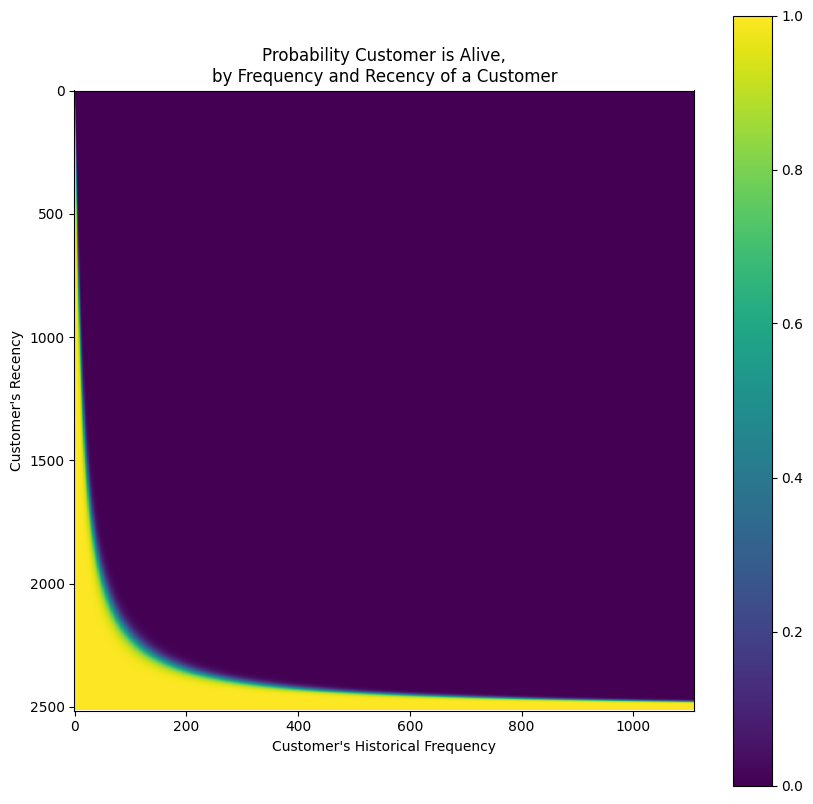

In [ ]:
plt.figure(figsize = (10, 10))
plot_probability_alive_matrix(bgf)

In [ ]:
alive_prob = bgf.conditional_probability_alive(frequency=data_full['frequency_cal'], 
                                               recency=data_full['recency_cal'], 
                                               T=data_full['T_cal'])
data_full['alive_prob'] = alive_prob
data_full

,frequency_cal,recency_cal,T_cal,frequency_holdout,duration_holdout,frequency,recency,T,in_d_c,in_d_f,alive_prob
partner,,,,,,,,,,,
0,133.0,2484.0,2489.0,4.0,95.0,137.0,2576.0,2584.0,5.0,27.0,0.999997
1,256.0,2496.0,2501.0,10.0,95.0,266.0,2595.0,2596.0,5.0,14.0,0.999998
2,54.0,2447.0,2452.0,3.0,95.0,57.0,2525.0,2547.0,5.0,29.0,0.999994
4,177.0,2493.0,2512.0,1.0,95.0,178.0,2548.0,2607.0,19.0,55.0,0.999994
9,87.0,2419.0,2498.0,0.0,95.0,87.0,2419.0,2593.0,79.0,100.0,0.999944
...,...,...,...,...,...,...,...,...,...,...,...
1668108,0.0,0.0,0.0,15.0,95.0,15.0,92.0,95.0,0.0,6.0,1.000000
1668153,0.0,0.0,0.0,31.0,95.0,31.0,94.0,95.0,0.0,3.0,1.000000
1668259,0.0,0.0,0.0,30.0,95.0,30.0,95.0,95.0,0.0,3.0,1.000000


In [ ]:
t = 95 - data_full['in_d_c']

expected_purchases = bgf.predict(t, frequency=data_full['frequency_cal'], 
                                  recency=data_full['recency_cal'], 
                                  T=data_full['T_cal'])

data_full['expected_purchases'] = expected_purchases
data_full

,frequency_cal,recency_cal,T_cal,frequency_holdout,duration_holdout,frequency,recency,T,in_d_c,in_d_f,alive_prob,expected_purchases
partner,,,,,,,,,,,,
0,133.0,2484.0,2489.0,4.0,95.0,137.0,2576.0,2584.0,5.0,27.0,0.999997,4.806272
1,256.0,2496.0,2501.0,10.0,95.0,266.0,2595.0,2596.0,5.0,14.0,0.999998,9.167410
2,54.0,2447.0,2452.0,3.0,95.0,57.0,2525.0,2547.0,5.0,29.0,0.999994,2.006643
4,177.0,2493.0,2512.0,1.0,95.0,178.0,2548.0,2607.0,19.0,55.0,0.999994,5.340363
9,87.0,2419.0,2498.0,0.0,95.0,87.0,2419.0,2593.0,79.0,100.0,0.999944,0.559553
...,...,...,...,...,...,...,...,...,...,...,...,...
1668108,0.0,0.0,0.0,15.0,95.0,15.0,92.0,95.0,0.0,6.0,1.000000,4.760449
1668153,0.0,0.0,0.0,31.0,95.0,31.0,94.0,95.0,0.0,3.0,1.000000,4.760449
1668259,0.0,0.0,0.0,30.0,95.0,30.0,95.0,95.0,0.0,3.0,1.000000,4.760449


In [ ]:
data_full['avarage_purchases'] = data_full['frequency_cal'] / data_full['recency_cal']
data_full['avarage_purchases'].fillna(0, inplace = True)
data_full

,frequency_cal,recency_cal,T_cal,frequency_holdout,duration_holdout,frequency,recency,T,in_d_c,in_d_f,alive_prob,expected_purchases,avarage_purchases
partner,,,,,,,,,,,,,
0,133.0,2484.0,2489.0,4.0,95.0,137.0,2576.0,2584.0,5.0,27.0,0.999997,4.806272,0.053543
1,256.0,2496.0,2501.0,10.0,95.0,266.0,2595.0,2596.0,5.0,14.0,0.999998,9.167410,0.102564
2,54.0,2447.0,2452.0,3.0,95.0,57.0,2525.0,2547.0,5.0,29.0,0.999994,2.006643,0.022068
4,177.0,2493.0,2512.0,1.0,95.0,178.0,2548.0,2607.0,19.0,55.0,0.999994,5.340363,0.070999
9,87.0,2419.0,2498.0,0.0,95.0,87.0,2419.0,2593.0,79.0,100.0,0.999944,0.559553,0.035965
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1668108,0.0,0.0,0.0,15.0,95.0,15.0,92.0,95.0,0.0,6.0,1.000000,4.760449,0.000000
1668153,0.0,0.0,0.0,31.0,95.0,31.0,94.0,95.0,0.0,3.0,1.000000,4.760449,0.000000
1668259,0.0,0.0,0.0,30.0,95.0,30.0,95.0,95.0,0.0,3.0,1.000000,4.760449,0.000000


In [ ]:
data_full['Churn'] = np.where(data_full['in_d_f'] >= 95, True, False)
data_full.drop(['duration_holdout', 'frequency_holdout','frequency', 'recency', 'T', 'in_d_f'], axis = 1).corr().style.background_gradient(cmap="vlag", vmin = -1, vmax=1)

,frequency_cal,recency_cal,T_cal,in_d_c,alive_prob,expected_purchases,avarage_purchases,Churn
frequency_cal,1.000000,0.574524,0.569136,-0.241605,-0.018481,0.511668,0.290703,-0.242640
recency_cal,0.574524,1.000000,0.999719,-0.037006,0.032948,-0.106098,-0.180909,-0.067278
T_cal,0.569136,0.999719,1.000000,-0.013308,0.030831,-0.118129,-0.186753,-0.052516
in_d_c,-0.241605,-0.037006,-0.013308,1.000000,-0.090087,-0.504518,-0.241838,0.624047
alive_prob,-0.018481,0.032948,0.030831,-0.090087,1.000000,0.026961,-0.115021,-0.059952
expected_purchases,0.511668,-0.106098,-0.118129,-0.504518,0.026961,1.000000,0.717520,-0.381647
avarage_purchases,0.290703,-0.180909,-0.186753,-0.241838,-0.115021,0.717520,1.000000,-0.201497
Churn,-0.242640,-0.067278,-0.052516,0.624047,-0.059952,-0.381647,-0.201497,1.000000


In [ ]:
data_full[data_full['Churn'] == True]['Churn'].count()

120251

In [ ]:
train, test = train_test_split(data_full, test_size=0.3, random_state=42)
x_train = train[['frequency_cal','recency_cal','T_cal','in_d_c', 'alive_prob', 'expected_purchases', 'avarage_purchases']]
y_train = train['Churn']
x_test = test[['frequency_cal','recency_cal','T_cal','in_d_c', 'alive_prob', 'expected_purchases', 'avarage_purchases']]
y_test = test['Churn']

result = pd.DataFrame(columns = ['Classifier', 'Precision', 'Recall', 'F1'])  

In [ ]:
LogReg = LogisticRegression(random_state=42).fit(x_train, y_train)
y_predict = LogReg.predict(x_test)
result = pd.DataFrame(np.array([['LogReg', round(precision_score(y_test, y_predict), 3), round(recall_score(y_test, y_predict), 3),
                                 round(f1_score(y_test, y_predict), 3)]]), columns=['Classifier', 'Precision', 'Recall', 'F1']).append(result, ignore_index=True)

In [ ]:
DTC = DecisionTreeClassifier(max_depth = 5, random_state=42).fit(x_train, y_train)
y_predict = DTC.predict(x_test)
result = pd.DataFrame(np.array([['DTC', round(precision_score(y_test, y_predict), 3), round(recall_score(y_test, y_predict), 3),
                                 round(f1_score(y_test, y_predict), 3)]]), columns=['Classifier', 'Precision', 'Recall', 'F1']).append(result, ignore_index=True)

In [ ]:
RFC = RandomForestClassifier(n_estimators=200, max_depth=3, random_state = 42, n_jobs=-1).fit(x_train, y_train)
y_predict = RFC.predict(x_test)
result = pd.DataFrame(np.array([['RFC', round(precision_score(y_test, y_predict), 3), round(recall_score(y_test, y_predict), 3),
                                 round(f1_score(y_test, y_predict), 3)]]), columns=['Classifier', 'Precision', 'Recall', 'F1']).append(result, ignore_index=True)

In [ ]:
GBC = GradientBoostingClassifier(n_estimators = 100, learning_rate = 1.0, max_depth = 2, random_state = 42).fit(x_train, y_train)
y_predict = GBC.predict(x_test)
result = pd.DataFrame(np.array([['GBC', round(precision_score(y_test, y_predict), 3), round(recall_score(y_test, y_predict), 3),
                                 round(f1_score(y_test, y_predict), 3)]]), columns=['Classifier', 'Precision', 'Recall', 'F1']).append(result, ignore_index=True)

In [ ]:
BC = BaggingClassifier(DecisionTreeClassifier(), n_estimators=100, random_state = 42).fit(x_train, y_train)
y_predict = BC.predict(x_test)
result = pd.DataFrame(np.array([['BC', round(precision_score(y_test, y_predict), 3), round(recall_score(y_test, y_predict), 3),
                                 round(f1_score(y_test, y_predict), 3)]]), columns=['Classifier', 'Precision', 'Recall', 'F1']).append(result, ignore_index=True)

result.sort_values('F1', ascending=False) 

,Classifier,Precision,Recall,F1
3,DTC,0.729,0.661,0.693
1,GBC,0.757,0.619,0.681
2,RFC,0.76,0.587,0.663
0,BC,0.699,0.615,0.655
4,LogReg,0.749,0.578,0.653


In [ ]:
scoring = {'f1': 'f1',
           'precision': 'precision',
           'recall': 'recall'}

scores = cross_validate(DTC, x_test, y_test, scoring=scoring, cv=ShuffleSplit(n_splits=5, random_state=42))
DF_cv = pd.DataFrame(scores)
print('Результаты Кросс-валидации \n', DF_cv, '\n')
print(round(DF_cv.mean()[2:], 2))

Результаты Кросс-валидации 
    fit_time  score_time   test_f1  test_precision  test_recall
0  0.491976    0.022790  0.683369        0.752910     0.625587
1  0.491147    0.040458  0.679645        0.765345     0.611204
2  0.713749    0.034244  0.688873        0.720633     0.659794
3  0.722188    0.034108  0.677490        0.793419     0.591120
4  0.718662    0.035003  0.673062        0.769639     0.598020 

test_f1           0.68
test_precision    0.76
test_recall       0.62
dtype: float64


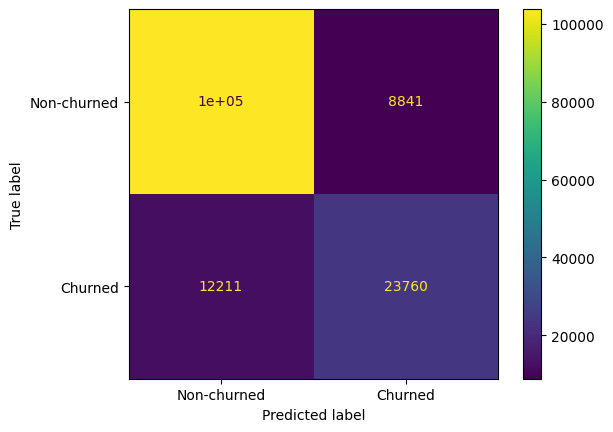

In [ ]:
y_predict = DTC.predict(x_test)
cm = confusion_matrix(y_test, y_predict)
cm_display = ConfusionMatrixDisplay(cm, display_labels=['Non-churned', 'Churned']).plot()

## Вручную

In [ ]:
data = pd.read_parquet('/content/drive/MyDrive/Practice/rfm_without_library.parquet.gzip')
data

,frequency,recency,T
partner,,,
0,138,2576,2584
1,267,2595,2596
2,58,2525,2547
3,7,2294,2519
4,179,2548,2607
...,...,...,...
1695379,4,1151,2403
1695380,3,454,2529
1695381,23,1998,2361


In [ ]:
data_cal_holdout = pd.read_parquet('/content/drive/MyDrive/Practice/rfm_cal_holdout_without_library.parquet.gzip')
data_cal_holdout

,frequency_cal,recency_cal,T_cal,frequency_holdout,duration_holdout
partner,,,,,
0,134,2484,2489,4.0,95
1,257,2496,2501,10.0,95
2,55,2447,2452,3.0,95
3,7,2294,2424,0.0,95
4,178,2493,2512,1.0,95
...,...,...,...,...,...
1695379,4,1151,2308,0.0,95
1695380,3,454,2434,0.0,95
1695381,23,1998,2266,0.0,95


In [ ]:
data_clear = data_cal_holdout[data_cal_holdout['T_cal'] - data_cal_holdout['recency_cal'] < 95]
data_clear

,frequency_cal,recency_cal,T_cal,frequency_holdout,duration_holdout
partner,,,,,
0,134,2484,2489,4.0,95
1,257,2496,2501,10.0,95
2,55,2447,2452,3.0,95
4,178,2493,2512,1.0,95
9,88,2419,2498,0.0,95
...,...,...,...,...,...
1667731,1,0,1,22.0,95
1667820,45,2449,2452,4.0,95
1667849,1,0,1,7.0,95


In [ ]:
data_full = pd.merge(data_clear, data, on = 'partner')
data_full

,frequency_cal,recency_cal,T_cal,frequency_holdout,duration_holdout,frequency,recency,T
partner,,,,,,,,
0,134,2484,2489,4.0,95,138,2576,2584
1,257,2496,2501,10.0,95,267,2595,2596
2,55,2447,2452,3.0,95,58,2525,2547
4,178,2493,2512,1.0,95,179,2548,2607
9,88,2419,2498,0.0,95,88,2419,2593
...,...,...,...,...,...,...,...,...
1667731,1,0,1,22.0,95,23,94,96
1667820,45,2449,2452,4.0,95,49,2545,2547
1667849,1,0,1,7.0,95,8,81,96


In [ ]:
data_full['in_d_c'] = data_full['T_cal'] - data_full['recency_cal']
data_full['in_d_f'] = round((data_full['recency'] - data_full['T_cal'])/ data_full['frequency_holdout']) + data_full['in_d_c']
data_full.loc[data_full['in_d_f'] < 0, 'in_d_f'] = 100
data_full['in_d_f'].fillna(100, inplace = True)
data_full

,frequency_cal,recency_cal,T_cal,frequency_holdout,duration_holdout,frequency,recency,T,in_d_c,in_d_f
partner,,,,,,,,,,
0,134,2484,2489,4.0,95,138,2576,2584,5,27.0
1,257,2496,2501,10.0,95,267,2595,2596,5,14.0
2,55,2447,2452,3.0,95,58,2525,2547,5,29.0
4,178,2493,2512,1.0,95,179,2548,2607,19,55.0
9,88,2419,2498,0.0,95,88,2419,2593,79,100.0
...,...,...,...,...,...,...,...,...,...,...
1667731,1,0,1,22.0,95,23,94,96,1,5.0
1667820,45,2449,2452,4.0,95,49,2545,2547,3,26.0
1667849,1,0,1,7.0,95,8,81,96,1,12.0


In [ ]:
bgf = BetaGeoFitter(penalizer_coef=0.0001)

bgf.fit(frequency=data_full['frequency_cal'], 
        recency=data_full['recency_cal'], 
        T=data_full['T_cal'])

<btyd.BetaGeoFitter: fitted with 494486 subjects, a: 0.00043521225464739744, alpha: 25.032695447883096, b: 1.2770330386845599, r: 1.350774279499388>

<Axes: title={'center': 'Probability Customer is Alive,\nby Frequency and Recency of a Customer'}, xlabel="Customer's Historical Frequency", ylabel="Customer's Recency">

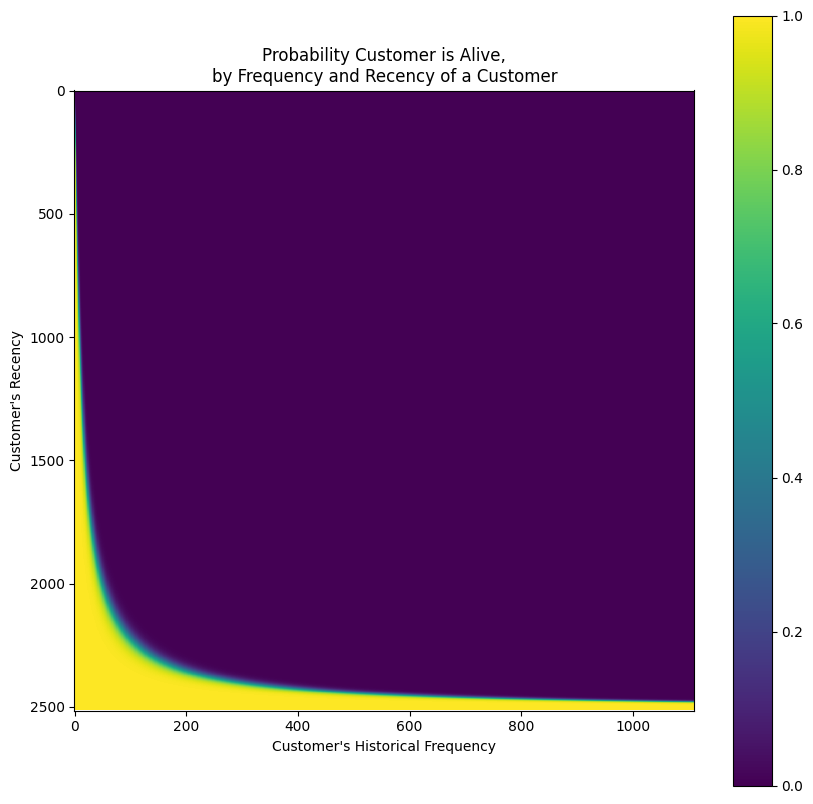

In [ ]:
plt.figure(figsize = (10, 10))
plot_probability_alive_matrix(bgf)

In [ ]:
alive_prob = bgf.conditional_probability_alive(frequency=data_full['frequency_cal'], 
                                               recency=data_full['recency_cal'], 
                                               T=data_full['T_cal'])
data_full['alive_prob'] = alive_prob
data_full

,frequency_cal,recency_cal,T_cal,frequency_holdout,duration_holdout,frequency,recency,T,in_d_c,in_d_f,alive_prob
partner,,,,,,,,,,,
0,134,2484,2489,4.0,95,138,2576,2584,5,27.0,0.999996
1,257,2496,2501,10.0,95,267,2595,2596,5,14.0,0.999997
2,55,2447,2452,3.0,95,58,2525,2547,5,29.0,0.999991
4,178,2493,2512,1.0,95,179,2548,2607,19,55.0,0.999991
9,88,2419,2498,0.0,95,88,2419,2593,79,100.0,0.999915
...,...,...,...,...,...,...,...,...,...,...,...
1667731,1,0,1,22.0,95,23,94,96,1,5.0,0.999626
1667820,45,2449,2452,4.0,95,49,2545,2547,3,26.0,0.999990
1667849,1,0,1,7.0,95,8,81,96,1,12.0,0.999626


In [ ]:
t = 95 - data_full['in_d_c']

expected_purchases = bgf.predict(t, frequency=data_full['frequency_cal'], 
                                  recency=data_full['recency_cal'], 
                                  T=data_full['T_cal'])

data_full['expected_purchases'] = expected_purchases
data_full

,frequency_cal,recency_cal,T_cal,frequency_holdout,duration_holdout,frequency,recency,T,in_d_c,in_d_f,alive_prob,expected_purchases
partner,,,,,,,,,,,,
0,134,2484,2489,4.0,95,138,2576,2584,5,27.0,0.999996,4.845372
1,257,2496,2501,10.0,95,267,2595,2596,5,14.0,0.999997,9.204681
2,55,2447,2452,3.0,95,58,2525,2547,5,29.0,0.999991,2.047403
4,178,2493,2512,1.0,95,179,2548,2607,19,55.0,0.999991,5.372592
9,88,2419,2498,0.0,95,88,2419,2593,79,100.0,0.999915,0.566576
...,...,...,...,...,...,...,...,...,...,...,...,...
1667731,1,0,1,22.0,95,23,94,96,1,5.0,0.999626,8.480600
1667820,45,2449,2452,4.0,95,49,2545,2547,3,26.0,0.999990,1.721492
1667849,1,0,1,7.0,95,8,81,96,1,12.0,0.999626,8.480600


In [ ]:
data_full['avarage_purchases'] = data_full['frequency_cal'] / data_full['recency_cal']
data_full['avarage_purchases'].fillna(0, inplace = True)
data_full.loc[data_full['avarage_purchases'] == np.inf, 'avarage_purchases'] = data_full['frequency_cal']
data_full

,frequency_cal,recency_cal,T_cal,frequency_holdout,duration_holdout,frequency,recency,T,in_d_c,in_d_f,alive_prob,expected_purchases,avarage_purchases
partner,,,,,,,,,,,,,
0,134,2484,2489,4.0,95,138,2576,2584,5,27.0,0.999996,4.845372,0.053945
1,257,2496,2501,10.0,95,267,2595,2596,5,14.0,0.999997,9.204681,0.102965
2,55,2447,2452,3.0,95,58,2525,2547,5,29.0,0.999991,2.047403,0.022477
4,178,2493,2512,1.0,95,179,2548,2607,19,55.0,0.999991,5.372592,0.071400
9,88,2419,2498,0.0,95,88,2419,2593,79,100.0,0.999915,0.566576,0.036379
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1667731,1,0,1,22.0,95,23,94,96,1,5.0,0.999626,8.480600,1.000000
1667820,45,2449,2452,4.0,95,49,2545,2547,3,26.0,0.999990,1.721492,0.018375
1667849,1,0,1,7.0,95,8,81,96,1,12.0,0.999626,8.480600,1.000000


In [ ]:
data_full['Churn'] = np.where(data_full['in_d_f'] >= 95, True, False)
data_full.drop(['duration_holdout', 'frequency_holdout','frequency', 'recency', 'T', 'in_d_f'], axis = 1).corr().style.background_gradient(cmap="vlag", vmin = -1, vmax=1)

,frequency_cal,recency_cal,T_cal,in_d_c,alive_prob,expected_purchases,avarage_purchases,Churn
frequency_cal,1.000000,0.574318,0.568948,-0.246566,-0.009422,0.464949,-0.098547,-0.242901
recency_cal,0.574318,1.000000,0.999722,-0.045009,0.048875,-0.169953,-0.374637,-0.067206
T_cal,0.568948,0.999722,1.000000,-0.021440,0.046213,-0.182283,-0.374627,-0.052457
in_d_c,-0.246566,-0.045009,-0.021440,1.000000,-0.114376,-0.516740,0.012877,0.627030
alive_prob,-0.009422,0.048875,0.046213,-0.114376,1.000000,0.037746,-0.054314,-0.077367
expected_purchases,0.464949,-0.169953,-0.182283,-0.516740,0.037746,1.000000,0.199930,-0.384883
avarage_purchases,-0.098547,-0.374637,-0.374627,0.012877,-0.054314,0.199930,1.000000,0.050316
Churn,-0.242901,-0.067206,-0.052457,0.627030,-0.077367,-0.384883,0.050316,1.000000


In [ ]:
data_full[data_full['Churn'] == True]['Churn'].count()

120183

In [ ]:
train, test = train_test_split(data_full, test_size=0.3, random_state=42)
x_train = train[['frequency_cal','recency_cal','T_cal','in_d_c', 'alive_prob', 'expected_purchases', 'avarage_purchases']]
y_train = train['Churn']
x_test = test[['frequency_cal','recency_cal','T_cal','in_d_c', 'alive_prob', 'expected_purchases', 'avarage_purchases']]
y_test = test['Churn']

result1 = pd.DataFrame(columns = ['Classifier', 'Precision', 'Recall', 'F1'])

In [ ]:
LogReg = LogisticRegression(random_state=42).fit(x_train, y_train)
y_predict = LogReg.predict(x_test)
result1 = pd.DataFrame(np.array([['LogReg', round(precision_score(y_test, y_predict), 3), round(recall_score(y_test, y_predict), 3),
                                 round(f1_score(y_test, y_predict), 3)]]), columns=['Classifier', 'Precision', 'Recall', 'F1']).append(result1, ignore_index=True)

In [ ]:
DTC = DecisionTreeClassifier(max_depth = 5, random_state=42).fit(x_train, y_train)
y_predict = DTC.predict(x_test)
result1 = pd.DataFrame(np.array([['DTC', round(precision_score(y_test, y_predict), 3), round(recall_score(y_test, y_predict), 3),
                                 round(f1_score(y_test, y_predict), 3)]]), columns=['Classifier', 'Precision', 'Recall', 'F1']).append(result1, ignore_index=True)

In [ ]:
RFC = RandomForestClassifier(n_estimators=200, max_depth=3, random_state = 42, n_jobs=-1).fit(x_train, y_train)
y_predict = RFC.predict(x_test)
result1 = pd.DataFrame(np.array([['RFC', round(precision_score(y_test, y_predict), 3), round(recall_score(y_test, y_predict), 3),
                                 round(f1_score(y_test, y_predict), 3)]]), columns=['Classifier', 'Precision', 'Recall', 'F1']).append(result1, ignore_index=True)

In [ ]:
GBC = GradientBoostingClassifier(n_estimators = 100, learning_rate = 1.0, max_depth = 2, random_state = 42).fit(x_train, y_train)
y_predict = GBC.predict(x_test)
result1 = pd.DataFrame(np.array([['GBC', round(precision_score(y_test, y_predict), 3), round(recall_score(y_test, y_predict), 3),
                                 round(f1_score(y_test, y_predict), 3)]]), columns=['Classifier', 'Precision', 'Recall', 'F1']).append(result1, ignore_index=True)

In [ ]:
BC = BaggingClassifier(DecisionTreeClassifier(), n_estimators=100, random_state = 42).fit(x_train, y_train)
y_predict = BC.predict(x_test)
result1 = pd.DataFrame(np.array([['BC', round(precision_score(y_test, y_predict), 3), round(recall_score(y_test, y_predict), 3),
                                 round(f1_score(y_test, y_predict), 3)]]), columns=['Classifier', 'Precision', 'Recall', 'F1']).append(result1, ignore_index=True)

result1.sort_values('F1', ascending=False)

,Classifier,Precision,Recall,F1
3,DTC,0.723,0.672,0.697
1,GBC,0.757,0.63,0.688
2,RFC,0.764,0.592,0.667
4,LogReg,0.751,0.59,0.661
0,BC,0.701,0.621,0.659


In [ ]:
scoring = {'f1': 'f1',
           'precision': 'precision',
           'recall': 'recall'}

scores = cross_validate(DTC, x_test, y_test, scoring=scoring, cv=ShuffleSplit(n_splits=5, random_state=42))
DF_cv = pd.DataFrame(scores)
print('Результаты Кросс-валидации \n', DF_cv, '\n')
print(round(DF_cv.mean()[2:], 2))

Результаты Кросс-валидации 
    fit_time  score_time   test_f1  test_precision  test_recall
0  0.501742    0.025045  0.683120        0.737986     0.635848
1  0.505207    0.022582  0.693963        0.753896     0.642857
2  0.511548    0.034794  0.683043        0.719122     0.650411
3  0.531088    0.023362  0.697272        0.747719     0.653201
4  0.553606    0.037848  0.696974        0.724076     0.671827 

test_f1           0.69
test_precision    0.74
test_recall       0.65
dtype: float64


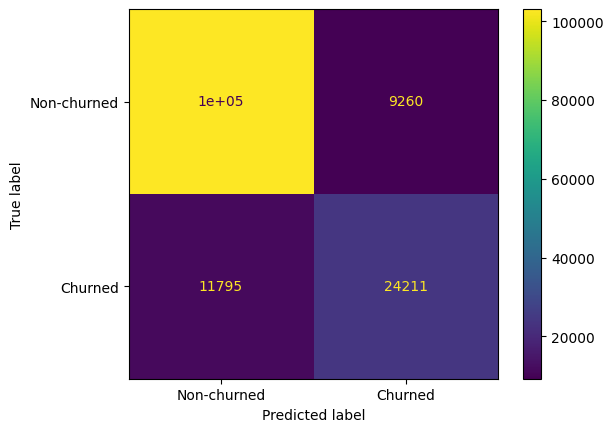

In [ ]:
y_predict = DTC.predict(x_test)
cm = confusion_matrix(y_test, y_predict)
cm_display = ConfusionMatrixDisplay(cm, display_labels=['Non-churned', 'Churned']).plot()

In [ ]:
with open('/content/drive/MyDrive/Practice/best_model.pkl', 'wb') as file:
    pickle.dump(DTC, file)

In [ ]:
with open('/content/drive/MyDrive/Practice/best_model.pkl', 'rb') as file:
    pickle_model = pickle.load(file)

pickle_model.predict(x_test)

print('Результаты на тестовых данных', '\n f1:', round(f1_score(y_test, y_predict), 3), 'precision:',
      round(precision_score(y_test, y_predict), 3), 'recall:', round(recall_score(y_test, y_predict), 3))

Результаты на тестовых данных 
 f1: 0.697 precision: 0.723 recall: 0.672
